# <center>Welcome to 21cmFirstCLASS Notebook #1!</center>
### <center>By J. Flitter and S. Libanore</center>
21cmFirstCLASS is an extension of the popular 21cmFAST code that interfaces with CLASS to generate initial conditions consistent with the input cosmological model. These initial conditions can be set during the time of recombination, allowing one to compute the 21cm signal (and its spatial fluctuations) throughout the dark ages, as well as in the proceeding cosmic dawn and reionization epochs, just like in the standard 21cmFAST.

#### In this notebook you will learn how to...
- Install the code and all the dependencies it requires
- Run the simulation while setting up basic properties
- Plot the power spectra used to generate initial boxes for the simulation
- Plot the global history of useful quantities 
- Plot the lightcones and coeval boxes of the different quantities in the simulation
- Plot the CMB power spectrum
- Compute and plot the 21cm power spectrum

## Installation

#### To run 21cmFirstCLASS, be sure that...
- You are using python 3.9 or later versions; we suggest you to create a separate conda environment to store this code inside it. <br>
  More info can be found here: https://saturncloud.io/blog/how-to-create-a-conda-environment-with-a-specific-python-version/ <br>

Before you start, check which gcc version is installed on your machine. If it is different than gcc-11, change setup.py at lines 30 and 31.

  In this environment, you need to install the following C libraries. <br>
  ```python
  conda install -c conda-forge gsl fftw
  ```

- You compiled the main 21cmFirstCLASS code; to do so, run in the terminal the following lines. <br>

    ```python
    python setup.py clean
    python setup.py install
    pip install . 
    ```

- You have CLASS installed and running properly in your environment. 
  You can download it by running in the terminal the following lines.
  ```python
  git clone https://github.com/lesgourg/class_public.git CLASS
  cd CLASS/
  make
  ```
  
- Your jupyter kernel refers to the same env where 21cmFirstCLASS has been compiled. 

## General definitions

In [1]:
# Import the packages required for this tutorial

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

import py21cmfast as p21c # To run 21cmFirstCLASS (21cmFAST)
from py21cmfast import plotting # For plotting global signals, coeval boxes, lightcone boxes and power spectra
import py21cmfast.power_spectrum as ps # Calculate power spectrum from the lightcone
from py21cmfast.inputs import global_params # Useful in this tutorial to plot the initial conditions for the simulation


------------------------------------------
!!! SLTK: 11/07/24
We defined the SF efficiency function using Fstar*M*fduty*Fesc. We defined the SFR function using 1/(tstar*H).
SFRD and Nion call separately either the SFR and the efficiency when using Fcoll.
 We added to ps.c function to compute the HMF and to the wrapper functions to compute HMF and LF. 

 Added SFR model from Bin Yue.

 NOTE: in IonisationBox, there is only one point in which the SFRD is required instead of Nion.
 For the moment, we collect the extra factor in the ST_over_PS factor but this is based on the assumption that the ratio is mass independent.
 Moreover, this uses the average value in the box instead of the value per cell, which introduces a variation < 2perc in Tb, < 6perc in Pk
------------------------------------------



It is VERY recommended for 21cmFirstCLASS users to have the 'latex' package installed in the same python environment where 21cmFirstCLASS is installed. <br>
If you have latex installed then you may run the next cell, otherwise do not run it as it will raise errors and no plots in this tutorial will be shown!

In [2]:
plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts

Define the color palette (this combination is good for colorblindness).

In [3]:
colors =  ['#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

## Set up parameters for the simulation

In this example notebook, we estimate the 21cm signal from recombination to reionization. 

- We assume &Lambda;CDM cosmological parameters from Planck 2018.

- We assume astrophysical parameters from EOS2021 (https://arxiv.org/abs/2110.13919).

The code requires more parameters than the ones listed, for which default values are used in this notebook. If you want to learn more, see Notebooks #2 and #3.

### Important Note!
To speed up the computation we use a rather small box with low resolution. Altough these settings are fine to obtain the correct global history, they are inadequate for studying the fluctuations of the box, or the power spectrum. Make sure to increase BOX_LEN and HII_DIM for reliable simulation of the power spectrum!

In [4]:
# Parameters related with the size of the simulation itself and with the kind of outputs required

user_params = {"BOX_LEN": 100, # size of the simulated box (in comoving Mpc) 
               "HII_DIM": 25, # number of cells along each axis of the coeval box - Note: more cells means longer runtime! 
               "N_THREADS": 6} # the amount of processors the code uses in parallelization

In [5]:
# Parameters that set the physical processes the code accounts for

flag_options = {"USE_MINI_HALOS": False, } # if False, popIII stars are not included - Note: if set to True, the runtime increases significantly!

In [6]:
# Cosmological parameters in LCDM

cosmo_params = {"hlittle": 0.6736, # hubble parameter
                "OMb": 0.0493, # baryon density
                "OMm": 0.3153, # matter (CDM+baryon) density
                "A_s": 2.1e-9, # amplitude of the primordial fluctuations
                "POWER_INDEX": 0.9649, # spectral index of the primordial spectrum
                "tau_reio": 0.0544, # optical depth to reionization
                }

In [7]:
# Astrophysical parameters in a standard scenario
# some parameters require to input the log10 value

astro_params = {"F_STAR10": -1.25, # star formation efficiency (atomic cooling galaxies) for pivot mass 1e10 Msun (log10)
                "ALPHA_STAR": 0.5, # slope of the dependency of star formation efficiency on the host halo mass 
                "F_ESC10": -1.35, # escape fraction of Lyman photons into the IGM for pivot mass 1e10 Msun (log10)
                "ALPHA_ESC": -0.3, # slope of the dependency of escape fraction on the host halo mass 
                "L_X": 40.5, # X-ray luminosity (log10)
        
# popIII stars parameters -- use only if USE_MINI_HALOS = True    
                #"F_STAR7_MINI": -2.5, # star formation efficiency (molecular cooling galaxies) for pivot mass 1e7 Msun (log10)
                #"ALPHA_STAR_MINI": 0., # slope of the dependency of star formation efficiency on the host halo mass 
                #"F_ESC7_MINI": -1.35, # escape fraction of Lyman photons into the IGM for molecular cooling galaxies, assumed constant as function of the halo mass (log10)
                # "L_X_MINI": 40.5, # Xray luminosity 
}


### Set up the required outputs

As in 21cmFAST, 21cmFirstCLASS allows you to extract the quantities evolved in the simulation using different formats.

- global quantity: store the quantity averaged over the full box, as a function of redshift 
- coeval boxes: store the box in which the quantity is computed at fixed redshift (you need to specify which redshift)
- lightcone quantity: store the quantity along the line-of-sight, to study how it evolves as a function of both space and time/redshift 

In principle, you can use the same key words in all the output kinds. <br>
Note however that the more lightcones and coeval boxes are stored, the more memory space is required.

In [8]:
global_quantities = ("brightness_temp", # brightness temperature
                     "Tk_box", # kinetic temperature
                     "Ts_box", # spin temperature
                     "xH_box", # neutral hydrogen fraction
                     "J_Lya_box", # Lyman alpha flux - new feature in 21cmFirstCLASS! 
                     "x_e_box") # free electron fraction

In [9]:
coeval_quantities = ["density", # matter density fluctuations 
                     "Tk_box",
                     "brightness_temp"]

input_coeval_redshifts = [6., 
                          10., 
                          15.]

In [10]:
lightcone_quantities = ("brightness_temp",
                        "density")

## Run the simulation

To run 21cmFirstCLASS we use the build-in 'run_lightcone' of 21cmFAST.<br>
Everything in 21cmFirstCLASS can then be accessed from the resulting lightcone object.

Also, note that 21cmFirstCLASS prints progress status messages. In this example, 172 (84) corresponds to the number of redshift iterations during the dark ages (cosmic dawn).

#### Note
If you wonder why the progress bar of the dark ages is filled more quickly towards the end - please see detailed discussion in Notebook #2!

In [11]:
lightcone = p21c.run_lightcone(redshift = 6., # minimum redshift at which the simulation will stop
                               random_seed = 1, # numerical seed -- if None, each run will produce different initial conditions, with the same cosmological power spectrum but different spatial realization. You need to specify the random seed to coherently compare two different runs, due to cosmic variance. 
                               regenerate = True, # create new data even if cached are found
                               write = False, # whether or no to save cached files
                               user_params = user_params,
                               astro_params = astro_params, 
                               flag_options = flag_options,
                               cosmo_params = cosmo_params,
                               global_quantities = global_quantities,
                               save_coeval_quantities = coeval_quantities,
                               save_coeval_redshifts = input_coeval_redshifts,
                               lightcone_quantities = lightcone_quantities) ; 

## Extract and plot initial conditions
By default, 21cmFirstCLASS updates global_params using the outputs of the CLASS run performed to generate the initial conditions; this assures that the cosmological model in the simulation is fully coherent with the input. The updated global_params can be used to extract useful quantities, e.g., the transfer functions required to compute the matter and velocity power spectra.

In [12]:
# Extract transfer functions and associated wavenumbers
k = pow(10.,np.array(global_params.LOG_K_ARR_FOR_TRANSFERS))[1:] # 1/Mpc
T_m0 = np.array(global_params.T_M0_TRANSFER)[1:]
T_vcb_kin = np.array(global_params.T_VCB_KIN_TRANSFER)[1:]

# Primordial curvature power spectrum
k_pivot = 0.05 # 1/Mpc
P_R = lightcone.cosmo_params.A_s * pow(k/k_pivot, lightcone.cosmo_params.POWER_INDEX-1.)

# Matter density power spectrum (at z=0)
P_m0 = 2.*np.pi**2 * P_R * T_m0**2/k**3
# Dimensionless baryon-CDM relative velocity power spectrum (at kinematic decoupling)
Delta_vcb_kin_sq = P_R * T_vcb_kin**2

Below we plot these power spectra.
#### Note
The next code section is planned to be part of 21cmFirstCLASS in its next version.

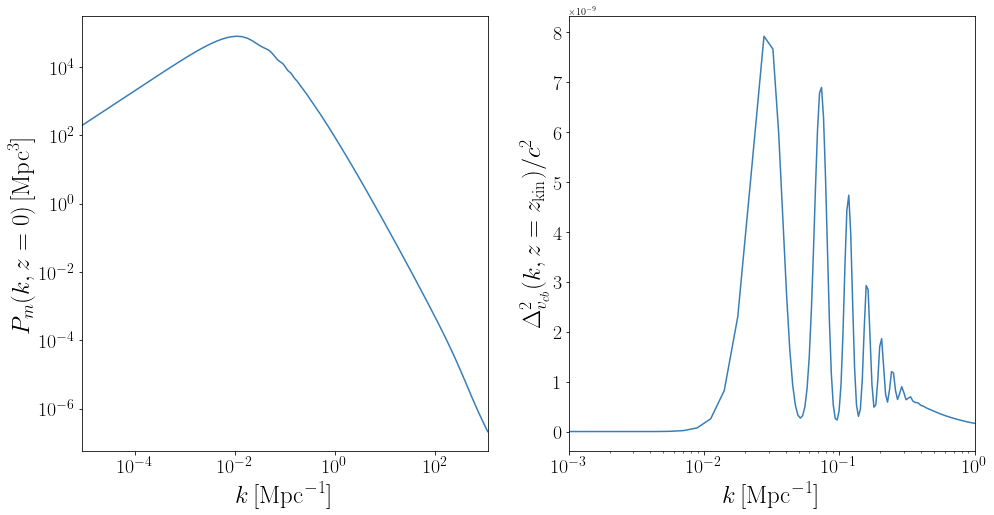

In [13]:
# Plot!
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].loglog(k,P_m0)
ax[1].semilogx(k,Delta_vcb_kin_sq)

# Prettify the plot
ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)
ax[0].set_xlabel(xlabel=r'$k\,[\mathrm{Mpc}^{-1}]$',fontsize=25)
ax[0].set_ylabel(ylabel=r'$P_m(k,z=0)\,[\mathrm{Mpc}^3]$',fontsize=25)
ax[0].set_xlim([min(k),max(k)])

# Prettify the plot
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)
ax[1].set_xlabel(xlabel=r'$k\,[\mathrm{Mpc}^{-1}]$',fontsize=25)
ax[1].set_ylabel(ylabel=r'$\Delta^2_{v_{cb}}(k,z=z_\mathrm{kin})/c^2$',fontsize=25)
ax[1].set_xlim([1e-3,1.]);

## Extract quantities from the lightcone object
If you want to extract the different quantities in the lightcone object, you can access them as we show below.

In [14]:
# All the global histories that were run are collected in the global_quantities dictionary

print(f'Stored global histories are {list(lightcone.global_quantities.keys())}')

# Note that the size of the redshift array (and also of the global histories) is equal to the redshift steps adopted in the above computation 
# (172 in the dark ages + 84 in the cosmic dawn = 256 in total)

print(f'Length of the redshift array = {np.shape(lightcone.node_redshifts)}')
print(f'Length of the global quantity array = {lightcone.global_quantities["brightness_temp"].shape}') ; 

Stored global histories are ['brightness_temp', 'Tk_box', 'Ts_box', 'xH_box', 'J_Lya_box', 'x_e_box']
Length of the redshift array = (256,)
Length of the global quantity array = (256,)


In [15]:
# You can access the coeval boxes that you previously stored through the following dictionary
output_coeval_redshifts = list(lightcone.coeval_boxes.keys())
print(f'Redshifts of stored coeval boxes = {output_coeval_redshifts}')

# Note that the redshifts in output_coeval_redshifts are not exactly the ones you provided in input_coeval_redshifts
# While running, 21cmFirstCLASS locates and uses the closest redshift in the ones used by the simulation

# Each dictionary contains the different coeval boxes you asked to store
print(f'Stored coeval boxes are {list(lightcone.coeval_boxes[output_coeval_redshifts[0]].keys())}')

# The 3d coeval boxes of each quantity can be accessed for each of the redshifts that were stored  
# Their size is set by HII_DIM

# For example, here we access the brightness temperature coeval box at z = 6 
# (in principle, you need to use the exact redshift values from output_coeval_redshifts, otherwise KeyError will be thrown)
coeval_box = lightcone.coeval_boxes[6.0]['brightness_temp']
print(f'Size of the coeval box = {coeval_box.shape}') ; 

Redshifts of stored coeval boxes = [15.080698632728584, 10.038290101897996, 6.0]
Stored coeval boxes are ['density', 'Tk_box', 'brightness_temp']
Size of the coeval box = (25, 25, 25)


In [16]:
# You can also access the lightcone quantities stored, as we show here

print(f'Stored lightcone boxes are {list(lightcone.lightcones.keys())}')

# These quantities are computed in a denser redshift array

print(f'Size of the redshift array associated with the lightcone boxes : {np.shape(lightcone.lightcone_redshifts)}')

# Here we access the lightcone box of the simulation.
# Note that its first two dimensions correspond to HII_DIM, while its last dimension is much longer

lightcone_box = lightcone.lightcones['brightness_temp']
print(f'Size of the lightcone box = {lightcone_box.shape}') ; 

Stored lightcone boxes are ['brightness_temp', 'density', 'baryons_density', 'xH_box']
Size of the redshift array associated with the lightcone boxes : (1359,)
Size of the lightcone box = (25, 25, 1359)


Since we ran CLASS, we also have the CMB power spectrum. For example, we can extract $C_\ell^\mathrm{TT}$ from the lightcone object with the following command (similarly, other modes, like EE, TE, BB, PP and TP can be extacted). 

This makes joint analysis of 21cm+CMB possible with 21cmFirstCLASS!

In [17]:
print(f'Size of ell array: {len(lightcone.Cl_data["ell"])}')
print(f'Size of C_ell^TT array: {len(lightcone.Cl_data["tt"])}')

Size of ell array: 3001
Size of C_ell^TT array: 3001


## Plot the lightcone outputs

Plotting in 21cmFirstCLASS is easy! All the automatic plotting functions are defined in the module
```python
plotting.py
```  
We use below these plotting functions. Note that the properties of the plots can be easily modified after the plots
were created.

### Global quantities
As a first example, we plot the global brightness temperature.


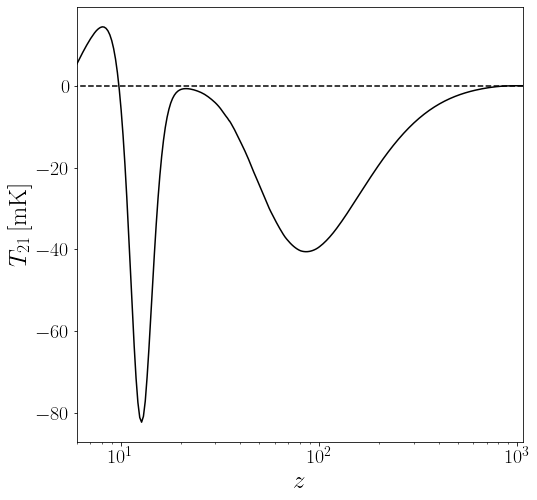

In [18]:
fig, ax = plotting.plot_global_history(lightcone,
                                       # you can specify the following properties for your plot; if None (or omitted) defaults are used
                                       kind = 'brightness_temp', # which quantity to plot, choose between the one listed in global_quantities
                                       x_kind='redshift', # this argument specifies plotted on the x-axis; can be set to 'redshift', 'frequency', or 'distance'
                                       xlabel = None,
                                       ylabel = None,
                                       xlog = None,
                                       ylog = None,
                                       # Note that this function accepts all the arguments of 'matplotlib.pyplot.plot'!
                                       color = 'k',
                                       ls='-',
                                       ) 

# Add a black horizontal dashed line at zero 

ax.plot([lightcone.node_redshifts[0],lightcone.node_redshifts[-1]],[0,0],color='k',ls='--') ; 


You can also plot more than one line in the same figure, and change the properties of the plot through the plotting.py module.

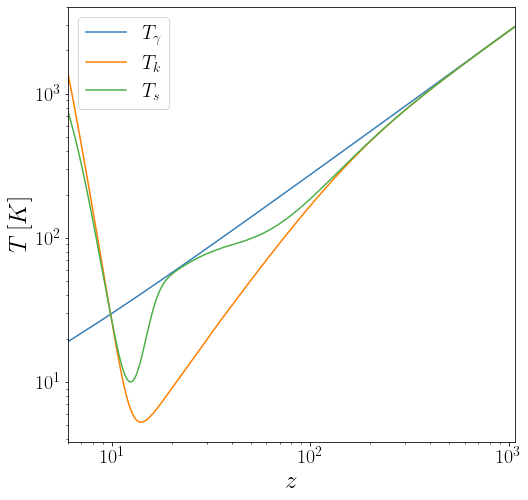

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the CMB temperature, which evolves as (1+z)
ax.plot(lightcone.node_redshifts,2.728*(1.+np.array(lightcone.node_redshifts)),label=r'$T_{\gamma}$')

# plot the kinetic temperature
fig, ax = plotting.plot_global_history(lightcone,kind='Tk_box',label=r'$T_k$',ax=ax)

# plot the spin temperature
fig, ax = plotting.plot_global_history(lightcone,kind='Ts_box',label=r'$T_s$',ax=ax)

# change the y-axis label
ax.set_ylabel(r'$T\, [K]$',fontsize=25) ; 


A new feature in 21cmFirstCLASS is that you can plot the Lyman alpha flux!

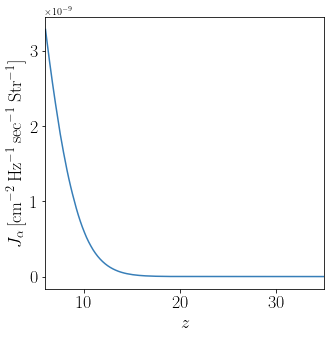

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5)) # set the plot size

fig, ax = plotting.plot_global_history(lightcone,
                                       kind='J_Lya_box',
                                       ax=ax)

# You can change the properties of the plot after it was created

ax.set_xlabel(xlabel=ax.get_xlabel(),fontsize=18)
ax.set_ylabel(ylabel=ax.get_ylabel(),fontsize=18)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.set_xlim([ax.get_xlim()[0],35])
ax.set_xscale('linear') ; 


### Coeval Boxes
Plotting coeval boxes in 21cmFirstCLASS is also easy. Unlike 21cmFAST, this can be achieved directly from the lightcone box object.

Note that when specifying the redshift of the coeval box to be plotted, the closest redshift from the stored coeval boxes is chosen.

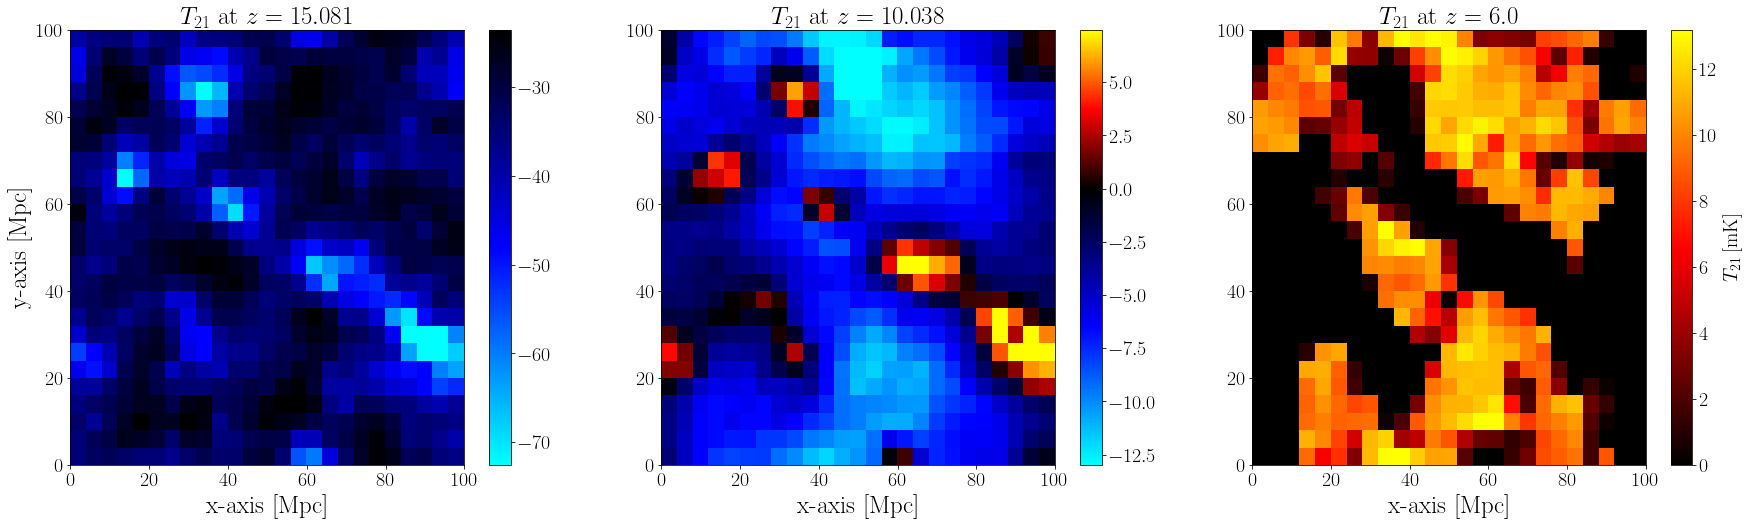

In [21]:
# Plot coeval boxes of the brightness temperature for different redshifts 

# plot the coeval boxes next to each other
fig, ax = plt.subplots(1, 3, figsize=(30, 8))

# First box: at z~15
fig = plotting.coeval_sliceplot(lightcone,
                                redshift=15,
                                ax=ax[0],
                                cbar_label='')

# Second box: at z~10
fig = plotting.coeval_sliceplot(lightcone,
                                redshift=10,
                                ax=ax[1],
                                cbar_label='')

# Third box: at z~6
fig = plotting.coeval_sliceplot(lightcone,
                                redshift=6,
                                ax=ax[2])

# Omit ylabels at the two rightmost plots
ax[1].set_ylabel('')
ax[2].set_ylabel('') ;

The default colormap for the brightness temperature in 21cmFirstCLASS is calibrated such that black regions correspond to null values (if the coeval box contains both positive and negative values). If only positive (negative) values in the coeval box exist, black regions correspond to the lowest (highest) values in the box.

We can also plot other coeval boxes we stored, like the kinetic temperature.

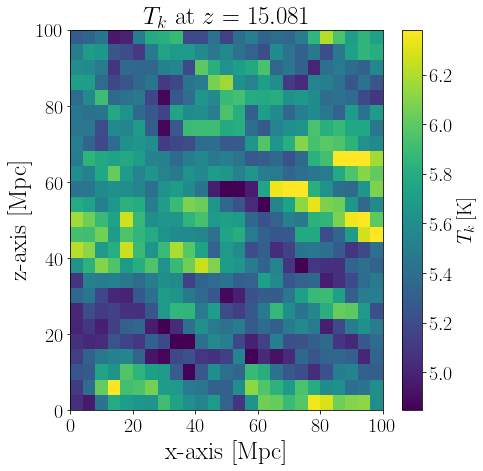

In [22]:
fig, ax, cb = plotting.coeval_sliceplot(lightcone,
                                        redshift=15,
                                        # you can specify the following properties for your plot; if None (or omitted) defaults are used
                                        kind='Tk_box',
                                        slice_axis=1, # this sets along which axis the box is sliced. 0 means 'x', 1 means 'y', 2 means 'z'
                                        slice_index=17, # the index of the chosen slice to be plotted, up to HII_DIM
                                        cbar=True, # whether or not to have a colorbar
                                        cbar_horizontal=None, # orientation of the colorbar
                                        cbar_label=None # label of colorbar
                                        # Note that this function accepts all the arguments of 'matplotlib.pyplot.imshow'!
                                       );

### Lightcones

In the example below we show how to plot the lightcone box of the brightness temperature next to the corresponding global signal for better comparison.


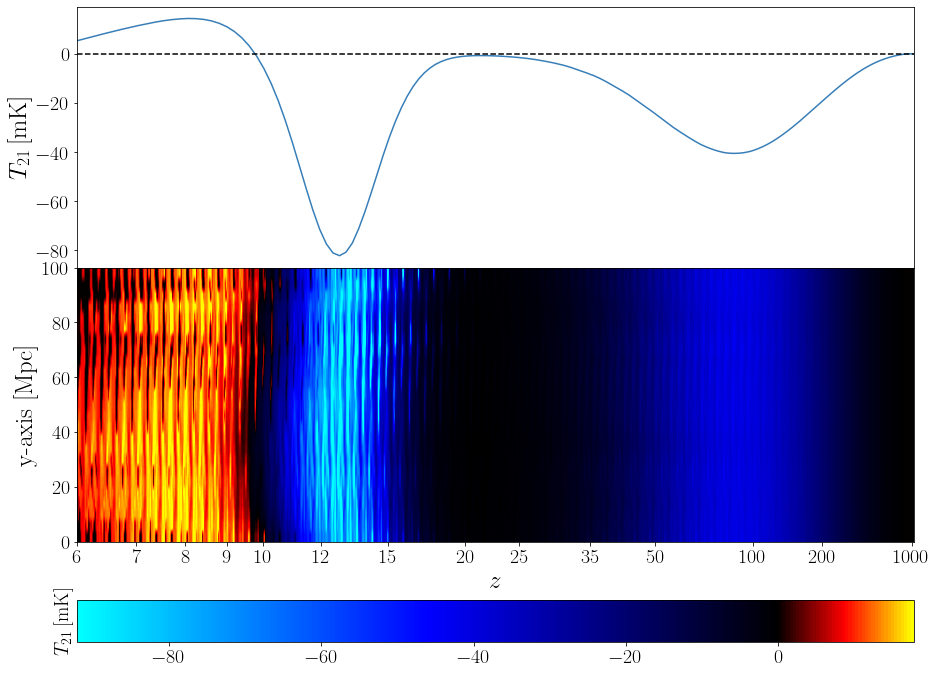

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12), sharex=True, gridspec_kw={'height_ratios': [1, 1.5]})

# plot the lightcone using the default color map
junk, junk, cb = plotting.lightcone_sliceplot(lightcone,
                                              ax=ax[1])

# plot the global signal evolution on top of the lightcone, with matching redshifts 
plotting.plot_global_history(lightcone,
                             x_kind='distance',
                             ax=ax[0])

# add horizontal line on the global signal 
ax[0].plot([lightcone.lightcone_coords[0],
            lightcone.lightcone_coords[-1]],
            [0,0],color='k',
            ls='--')

fig.subplots_adjust(hspace=0) ; 

### Important Note!
The repetitions seen along the line-of-sight are the consequence of using a small box. If we want to get rid of them, we need to increase BOX_LEN. To reach the same resolution, we need to increase HII_DIM as well, at the cost of increasing runtime.

We can plot any other stored lightcone box, like the density field. <br>
In the example below, we plot the lightcone box vertically, with comoving distance ticks.

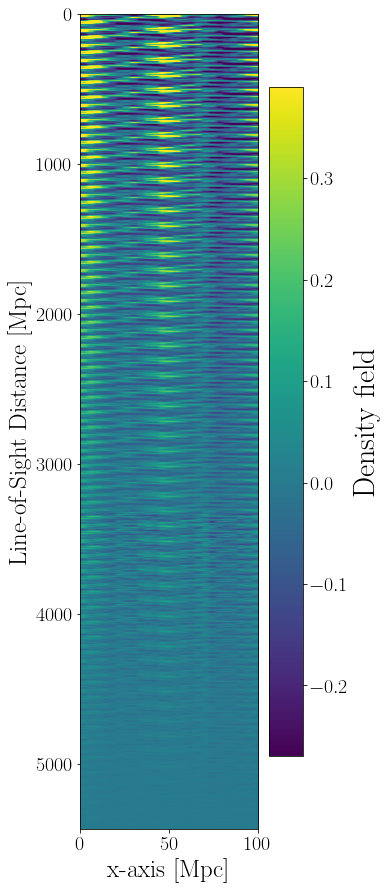

In [24]:
fig, ax, cb = plotting.lightcone_sliceplot(lightcone,
                                           # you can specify the following properties for your plot; if None (or omitted) defaults are used
                                           kind='density',
                                           zticks='distance', # Ticks along the line-of-sight, can be 'redshift', 'frequency' or 'distance'
                                           vertical=True,
                                           slice_index=17, # the index of the chosen slice to be plotted, up to HII_DIM
                                           slice_axis=1, # this sets along which axis the box is sliced. 0 means 'x', 1 means 'y'
                                           cbar=True, # whether or not to have a colorbar
                                           cbar_horizontal=None, # orientation of the colorbar
                                           cbar_label=None # label of colorbar
                                           # Note that this function accepts all the arguments of 'matplotlib.pyplot.imshow'!
                                          ) ;

# you can also modify the colorbar after it was created
cb.set_label('Density field',fontsize=30)

### CMB power spectrum
The plotting module of 21cmFirstCLASS enables to easily plot the CMB power spectrum.

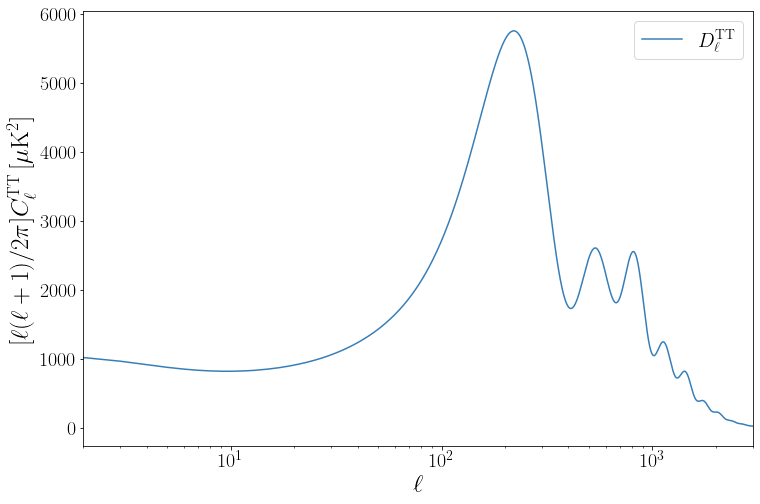

In [25]:
plotting.plot_Cl_data(lightcone,
                      # you can specify the following properties for your plot; if None (or omitted) defaults are used
                      mode='TT', # kind of CMB power spectrum to plot. Can be "TT" "EE", "TE", "BB", "PP" or "TP". Lowercase strings can be used as well
                      xlabel = None,
                      ylabel = None,
                      xlog = True,
                      ylog = None,     
                      Dl_plot=True, # Whether to plot D_ell = (ell(ell+1)/(2*pi))*C_ell in units of (micro-K)^2
                      # Note that this function accepts all the arguments of 'matplotlib.pyplot.plot'!
                      label=r'$D_\ell^\mathrm{TT}$');

## Compute the power spectrum 

To compute the power spectrum in the box, 21cmFirstCLASS relies on the powerbox package, and on the functions defined in the module
```python
power_spectrum.py
```
    

To compute the power spectrum, the lightcone is divided into redshift chunks.<br>
In each chunk, the power spectrum is evaluated as a function of k.

By default, the k-bins are determined from logarithmically spacing between the minimum and maximum wavenumbers
\begin{equation}
k_{\rm min} = \frac{2\pi}{\rm BOX\_LEN}\quad\quad k_{\rm max} = k_{\rm min}\times {\rm HII\_DIM}
\end{equation}
with a spacing factor = 1.5. Thus, the amount of k-bins is 
\begin{equation}
n_k = {\rm ceil}[\log_{1.5}({\rm HII\_DIM})]-1.
\end{equation}

The redshift bins can be defined in two ways:

- Such that the lightcone box is divided into equal-size chunks along the line-of-sight, thus all chunks have the same size in comoving coordinates. <br>
Note that:
    - If OUTPUT_AT_DARK_AGES = False, the number of chunks corresponds to the number of redshift bins used for the cosmic dawn.
    - If OUTPUT_AT_DARK_AGES = True, the code uses both during cosmic dawn and the dark ages a number of redshift bins equal to the number of chunks. Namely, if we input 15 chunks we obtain the power spectrum in 30 redshift bins.

- Correspondingly to the frequency bands of a given experiment. <br>
In this case, you need to input the frequency range and resolution; for each frequency bin, the code then estimates corresponding chunk and redshift bin. <br>
Note that you need to specify different experiments for the cosmic dawn or dark ages.

In this tutorial, we compute the power spectrum three times: 
- from the lightcone box, over the full redshift range, specifying explicitly the number of chuncks.
- from the lightcone box, during the cosmic dawn in the frequency bands observed by HERA.
- from the coeval box at z~15.

In [26]:
# first time: compute the power spectrum from the lightcone box in equally spaced chunks
power_spectrum_lightcone = ps.lightcone_power_spectrum(lightcone,
                                                       nchunks = 15) ;

In [27]:
# second time: compute the power spectrum from the lightcone box in HERA bands

# define the frequency range (50-250 MHz) and resolution (8 MHz) 
freq_bands_boundaries = np.arange(50.,225.+8.,8.); freq_bands_boundaries[-1] = 225.

power_spectrum_HERA = ps.lightcone_power_spectrum(lightcone,
                                                  freq_bands_boundaries = freq_bands_boundaries) ; 

In [28]:
# third time: compute the power spectrum from the coeval box at z~15
power_spectrum_coeval = ps.coeval_power_spectrum(lightcone,redshift=15.) ; 

## Extract quantities from the power spectrum object
You can access the $k$, $z$ and $\Delta_{21}^2(k,z)$ values from the power spectrum object as we show here.

In [29]:
print(f'Size of the k array: {power_spectrum_lightcone.k_values.shape}') # the size of the k array is set by H_II
print(f'Size of the z array: {power_spectrum_lightcone.z_values.shape}') # the size of the z array is twice the number of chunks 
print(f'Size of the power spectrum matrix: {power_spectrum_lightcone.ps_values.shape}') ; 

Size of the k array: (7,)
Size of the z array: (30,)
Size of the power spectrum matrix: (30, 7)


For the coeavl box, we only have a single redshift value that matches with the redshift of the coeval box.

In [30]:
print(f'Redshift of power spectrum from coeval box is z = {power_spectrum_coeval.z_values[0]}.')

Redshift of power spectrum from coeval box is z = 15.081.


# Plot the power spectrum
### Important Note!
The following power spectrum plots are imprecise, especially when we plot the power spectrum as a function of $k$, as we have set a small box with very low resolution!
In order to achieve the correct power spectrum, you must increase BOX_LEN and HII_DIM!

The 21cm power spectrum is essentially a function of two arguments, $z$ and $k$. Since we store $\Delta_{21}^2(k,z)$ in the form of a matrix, it is most natural to present this matrix as a 2d image. We use logarithmic values as the power spectrum can change by orders of magnitude.

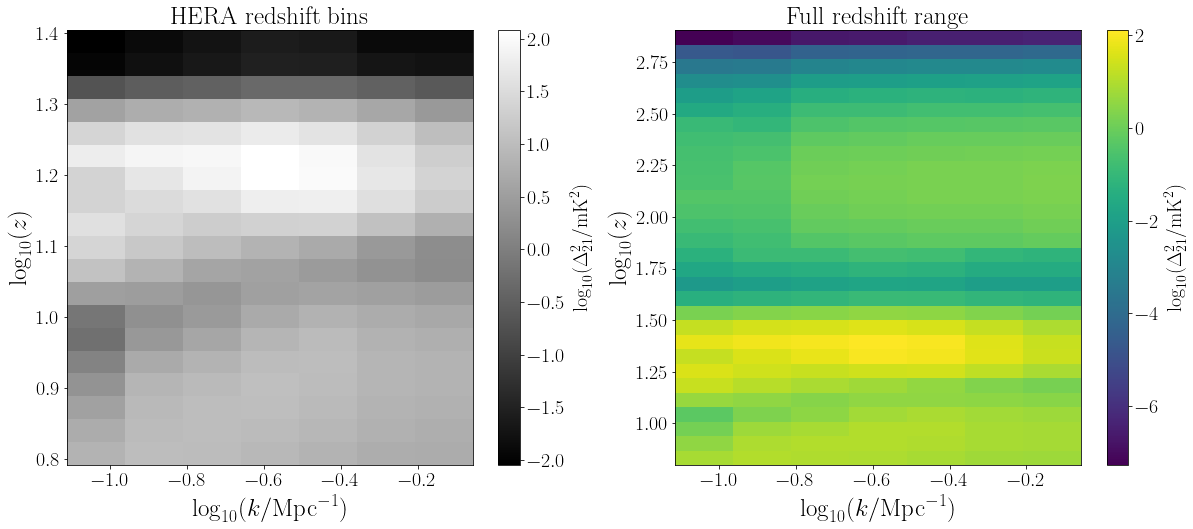

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

fig, junk, cb1 = plotting.plot_2d_power_spectrum(power_spectrum_HERA,
                                                 # you can specify the following properties for your plot; if None (or omitted) defaults are used
                                                 cbar=True, # whether or not to have a colorbar
                                                 cbar_horizontal=None, # orientation of the colorbar
                                                 cbar_label=None, # label of colorbar
                                                 # Note that this function accepts all the arguments of 'matplotlib.pyplot.imshow'!
                                                 # For example, here we change the colormap with the 'cmap' argument
                                                 cmap = 'gray',
                                                 ax = ax[0])

fig, junk, cb2 = plotting.plot_2d_power_spectrum(power_spectrum_lightcone,
                                                 ax = ax[1])

# set titles
ax[0].set_title('HERA redshift bins',fontsize=25)
ax[1].set_title('Full redshift range',fontsize=25) ;

While the above plots give us a complete picture for $\Delta_{21}^2(k,z)$ they are hard to interpret, as we cannot compare between power spectra of different scenarios. Plus, we cannot present instrumental noise on top of the 2d signal. This is why a 1d plot representation of the power spectrum is often useful.

As a first example, we plot the power spectrum as a function of $z$, for $k=0.3\,\mathrm{Mpc}^{-1}$. Note that this particular wavenumber is not part of our power spectrum data. Thus, the plotting module of 21cmFirstCLASS interpolates the above 2d image to estimate the 1d power spectrum at the desired wavenumber.

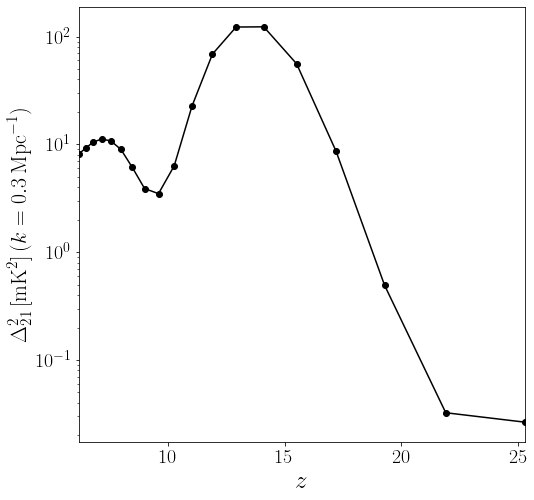

In [32]:
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_HERA,
                                          k=0.3, # scale in units 1/Mpc
                                          # you can specify the following properties for your plot; if None (or omitted) defaults are used
                                          smooth=None, # the curve can be smoothed by interpolating in intermediate points
                                          xlabel = None,
                                          ylabel = None,
                                          xlog = None, # linear scale on the x-axis by default
                                          ylog = None, # log scale on the y-axis by default
                                          # Note that this function accepts all the arguments of 'matplotlib.pyplot.plot'!
                                          color = 'k',
                                          ls='-',
                                          marker='o')

The above plot does not look too smooth, especially at the high redshifts. We can fix that by setting the 'smooth' flag on True. Then, intermediate points are added between the above data points. This is done with cubic interpolation. Note that the interpolation is adjusted to fit the scales of the x and y axes of the plot, in order to smooth the curve in the most natural way.

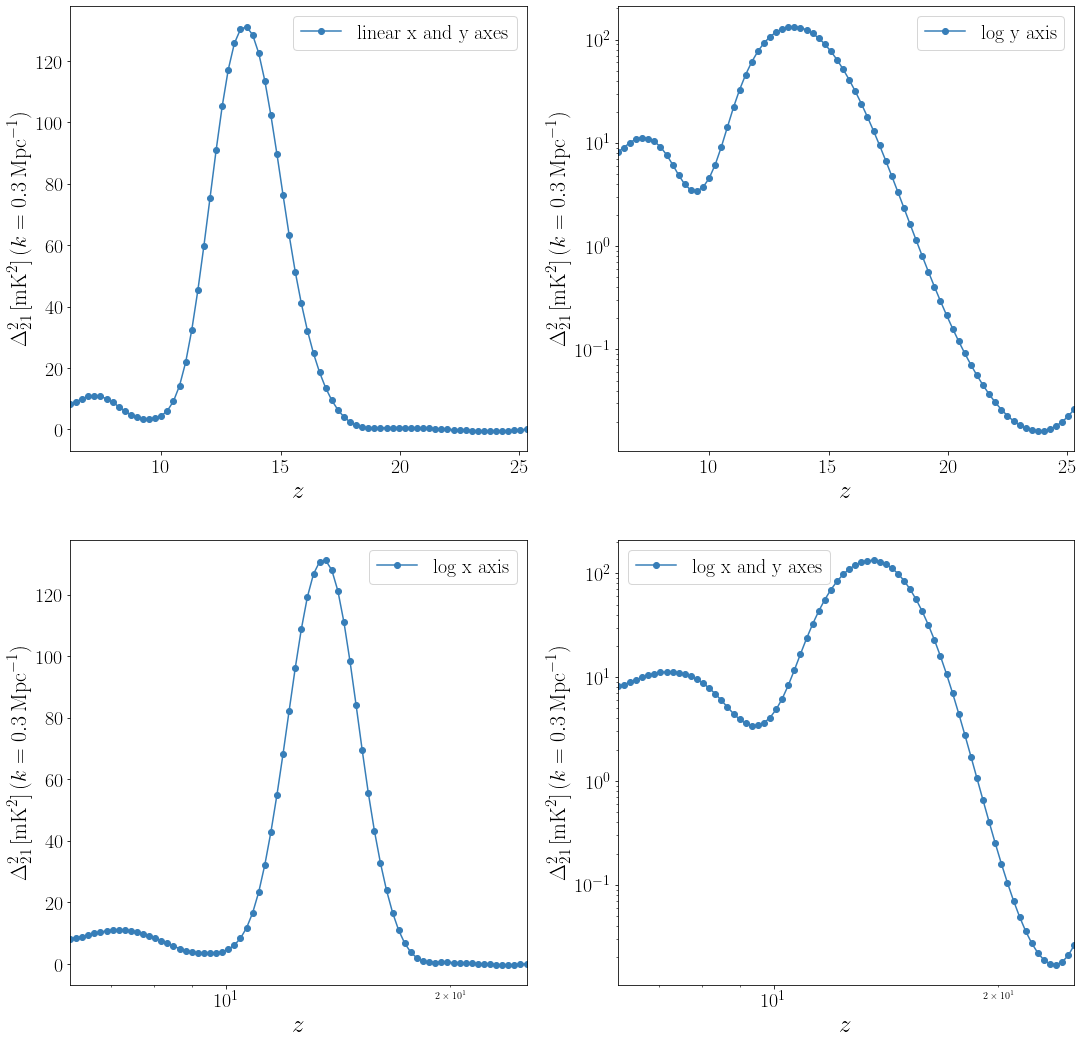

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(18, 18))


plotting.plot_1d_power_spectrum(power_spectrum_HERA,
                                k=0.3, # scale in units 1/Mpc
                                smooth=True, 
                                xlog = False,
                                ylog = False,
                                label = 'linear x and y axes',
                                marker='o',
                                ax=ax[0,0])

plotting.plot_1d_power_spectrum(power_spectrum_HERA,
                                k=0.3, # scale in units 1/Mpc
                                smooth=True, 
                                xlog = True,
                                ylog = False,
                                label = 'log x axis',
                                marker='o',
                                ax=ax[1,0])

plotting.plot_1d_power_spectrum(power_spectrum_HERA,
                                k=0.3, # scale in units 1/Mpc
                                smooth=True, 
                                xlog = False,
                                ylog = True,
                                label = 'log y axis',
                                marker='o',
                                ax=ax[0,1])

plotting.plot_1d_power_spectrum(power_spectrum_HERA,
                                k=0.3, # scale in units 1/Mpc
                                smooth=True, 
                                xlog = True,
                                ylog = True,
                                label = 'log x and y axes',
                                marker='o',
                                ax=ax[1,1]);

These plots look better! However, the cubic interpolation tends to produce wavy artifacts, especially when the samples are far from each other. In our case, we don't have many samples at the high $z$ values, since we determined the location of the chunks based on HERA frequency bands.

Thus, it is more natural to plot the power spectrum as a function of frequency rather than redshift. This can be done by specifying an 'x_kind' argument.

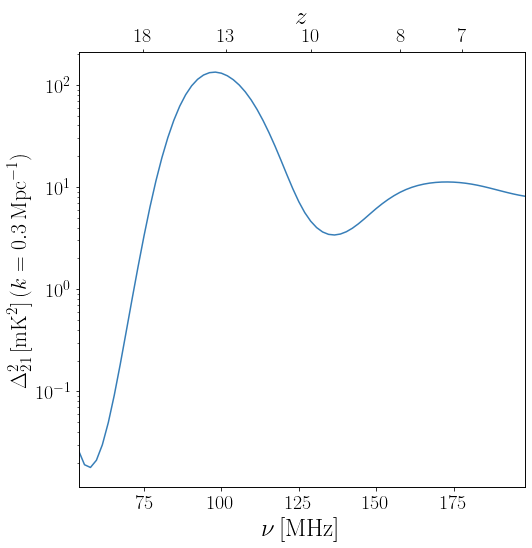

In [34]:
fig, ax1 = plotting.plot_1d_power_spectrum(power_spectrum_HERA,
                                           k=0.3, # scale in units 1/Mpc
                                           smooth=True,
                                           x_kind = 'frequency', # can be either 'redshift' or 'frequency'
                                           redshift_axis_on_top = True) # put redsfhit axis on top (applicable only if x_kind = 'frequency') 

When plotting the power spectrum for the full redshift of our simulation, as we have not specified frequency bands of a particular experiment, the most natural x-axis would be comoving distance. Yet, it is less intuitive to visulaize the power spectrum as a function of distance, so we plot it as a function of frequency.

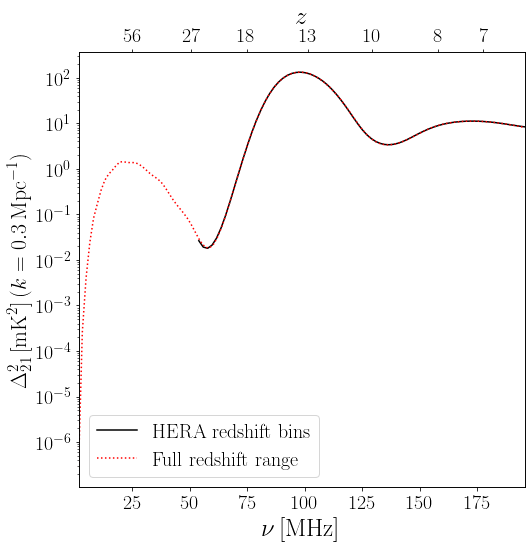

In [35]:
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_HERA,
                                          k=0.3, # scale in units 1/Mpc
                                          smooth=True,
                                          x_kind = 'frequency',
                                          color = 'k',
                                          ls='-',
                                          label='HERA redshift bins') 

# add the full redshift power spectrum on the previous plot
plotting.plot_1d_power_spectrum(power_spectrum_lightcone,
                                ax = ax, # by providing the same ax in input, you plot the lines in the same figure 
                                k=0.3, 
                                smooth=True,
                                x_kind = 'frequency',
                                redshift_axis_on_top = True,
                                color = 'r',
                                ls=':',
                                label='Full redshift range') ;

Now, we plot the power spectrum as a function of $k$, for $z\approx15$.

Note that while we interpolate the power spectrum from the lightcone box at the input redshift, the power spectrum from the coeval box is evaluated at the redshift of that coeval box, in this case it is $z=15.081$.

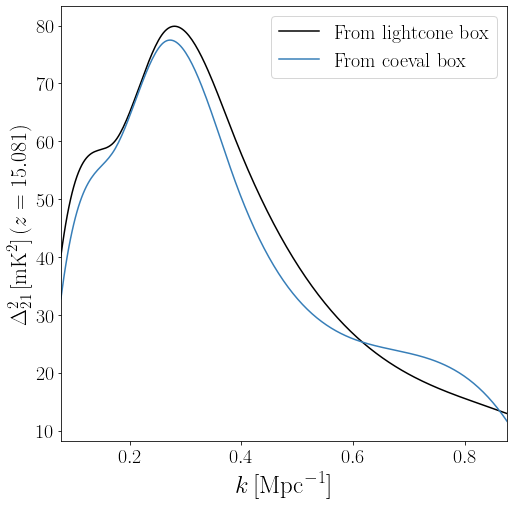

In [36]:
# the input are the same as in the previous case, you just need to specify z instead of k
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_lightcone,
                                          z=15.081, # redshift, for best comparison we take the redshift of the coeval box
                                          smooth=True,
                                          color='k',
                                          label='From lightcone box')

# You can compare the power spectrum computed in the lightcone with the power spectrum extracted from a coeval box
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_coeval,
                                          smooth=True,
                                          label='From coeval box',
                                          ax=ax) ;

Similarly, we can specify a frequency rather than redshift.

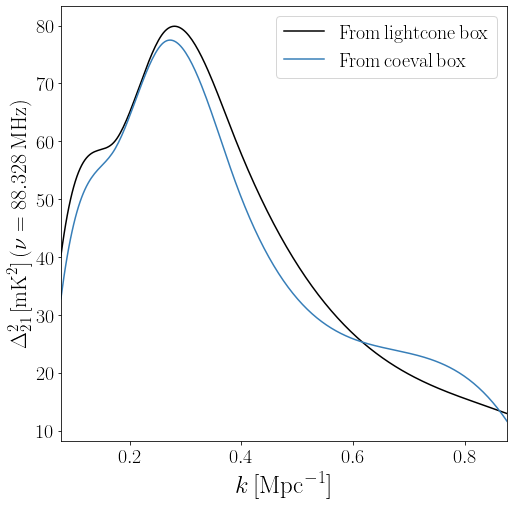

In [37]:
# frequency that matches z=15.081
f_21 = 1420.40575177 # MHz - Frequency of the 21cm line
z = 15.081
nu = f_21/(1.+z)

# the input are the same as in the previous case, you just need to specify nu instead of z
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_lightcone,
                                          nu=nu, # frequency in MHz
                                          smooth=True,
                                          color='k',
                                          label=r'$\rm From\, lightcone\, box$')

# Get ylabel
ylabel = ax.get_ylabel()

# You can compare the power spectrum computed in the lightcone with the power spectrum extracted from a coeval box
fig, ax = plotting.plot_1d_power_spectrum(power_spectrum_coeval,
                                          smooth=True,
                                          label=r'$\rm From\, coeval\, box$',
                                          ax=ax) ;


# If we don't want to show all the digits of the closest frequency, we can use the following lines
ylabel_parts = ylabel.split('\\nu=')
nu = float(ylabel_parts[1].split(r'\,')[0])
nu_str = '{:.3f}'.format(nu)
ylabel = r'%s$'%ylabel_parts[0] + r'$\nu=%s$'%nu_str + r'$\,\mathrm{MHz})$'
ax.set_ylabel(ylabel) ;

## Great, you reached the end of Notebook #1!

If you want to learn more about 21cmFirstCLASS and its application, you can continue with...

- Notebook #2 , for learning about the new features of 21cmFirstCLASS (in &Lambda;CDM cosmology)

- Notebook #3 , to study beyond &Lambda;CDM cosmology

- Notebook #4 , to study the detectability of the 21cm power spectrum with upcoming experiments


#### If you have questions or you find bugs, feel free to email us!
jordanf@post.bgu.ac.il

libanore@bgu.ac.il